In [14]:
!pip install audiomentations -q

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import wandb
import torch.utils
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os
import pytorch_lightning as pl
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision
from audiomentations import AdjustDuration, Normalize
from sklearn.metrics import f1_score, recall_score
import numpy as np

#### Defining some functions for loading the dataset, such as normalizing the Mel Spectogram, extracting the metadata, for the imbalanced dataset we are using class weighting, and we are also endocing our labels

In [16]:
def normalize_mel_spectrogram(mel_spec_tensor):
    min_value = mel_spec_tensor.min()
    max_value = mel_spec_tensor.max()
    normalized_mel_spec = (mel_spec_tensor - min_value) / (max_value - min_value)
    return normalized_mel_spec

def extract_metadata(metadata_file):
    metadata_df = pd.read_csv(metadata_file)
    metadata_df['Filename'] = metadata_df['Filename'].apply(lambda x: x.split("/")[-1])
    metadata = metadata_df[['Label', 'Filename']].reset_index(drop=True)
    metadata.columns = ['label', 'filename']
    return metadata

def encode_labels(labels):
    unique_labels = labels.unique()
    encoded_dict = {label: num for label, num in zip(unique_labels, range(len(unique_labels)))}
    return encoded_dict

#### Defining Our Custom Audio Classification Dataset

In [17]:
class AudioClassificationDataset(Dataset):
    def __init__(self, data_dir, metadata_file, transform=None, batch_size=10):
        self.data_dir = data_dir
        self.metadata = extract_metadata(metadata_file)
        self.transform = transform
        self.batch_size = batch_size
        self.label_encoder = encode_labels(self.metadata['label'])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        label = self.metadata['label'][idx]
        filename = self.metadata['filename'][idx]
        audio_file = os.path.join(self.data_dir, label, filename) 
        try:
            waveform, sample_rate = librosa.load(audio_file, sr=None)
        except Exception as e:
            print(f"Error loading audio file {audio_file}: {e}")
            return None
        normalization_transform = Normalize(p=1.0)
        duration_transform = AdjustDuration(duration_seconds=10,padding_mode="wrap", p=1.0)
        waveform = normalization_transform(waveform, sample_rate=sample_rate)
        waveform = duration_transform(waveform, sample_rate=sample_rate)
        mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, fmin=800, fmax=12000)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_db = normalize_mel_spectrogram(mel_spectrogram_db)
        mel_spec_db_tensor = torch.from_numpy(mel_spectrogram_db).unsqueeze(0)
        class_label = self.label_encoder[label]
        class_label_tensor = torch.tensor(class_label).unsqueeze(0)
        return mel_spec_db_tensor, class_label_tensor

#### Making our audio classifier testing class where we are collecting the true labels of the current batch in y_true and the prediction labels of the model in y_pred and also the prediction probabilities in y_prob lists  

In [54]:
class AudioClassifier(pl.LightningModule):
    def __init__(self, model):
        super(AudioClassifier, self).__init__()    
        self.model = model
        self.y_true = []
        self.y_pred = []
        self.y_prob = []
        
    def forward(self, x): 
        return self.model(x)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()
        y_pred = self(x)
        test_loss = F.cross_entropy(y_pred, y)
        y_proba = F.softmax(y_pred, dim=1)
        y_pred = torch.argmax(self(x), dim=1)
        test_acc = torch.sum(y_pred == y).item() / y.size(0)
        self.y_true.extend(y.cpu().numpy())
        self.y_pred.extend(y_pred.cpu().numpy())
        self.y_prob.extend(y_proba.cpu().numpy())
        self.log('test_loss', test_loss.item(), on_epoch=True)
        self.log('test_acc', test_acc, on_epoch=True)
     
    def get_results(self):
        return self.y_true,self.y_pred,self.y_prob

#### Initializing the test dataset with the filtered metadata

In [19]:
data_dir = '/kaggle/input/birdclef-2023/train_audio'
metadata_file = '/kaggle/input/filtered-metadata/filtered_metadata.csv'
test_dataset = AudioClassificationDataset(data_dir, metadata_file)

#### We are loading the test indicies that we had saved earlier as `test_incidies.pkl` in the `training.ipynb` 

In [20]:
with open('/kaggle/input/birdclef-test-indicies/test_indices.pkl', 'rb') as f:
    test_indices = pickle.load(f)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, sampler=test_sampler,num_workers=3)

#### From WandB we are loading our best performing model's saved checkpoint

In [21]:
run = wandb.init()
model_name = 'model-r4t5mun3:v15'
artifact = run.use_artifact('deepbirding/deepbirding/' + model_name, type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model-r4t5mun3:v15, 81.82MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


#### We are initializing the model according to the downloaded checkpoint and modifying its input and output according to our monochrome input Mel Spectogram and to our number of classes in the output as 264

In [22]:
num_classes = 264
eval_model = torchvision.models.resnet34(pretrained=True)
eval_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
eval_model.fc = nn.Linear(eval_model.fc.in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### We load the model weights of the best state checkpoint to the initialized model

In [23]:
checkpoint = torch.load(f'/kaggle/working/artifacts/{model_name}/model.ckpt')
eval_model.load_state_dict(checkpoint['state_dict'])
eval_model.eval()

In [55]:
eval_model = AudioClassifier(eval_model)
trainer = pl.Trainer(accelerator="gpu",devices=1, precision="16-mixed")

#### Running a test on the testing dataset

In [56]:
results = trainer.test(eval_model, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5402201414108276     │
│         test_loss         │     2.431685447692871     │
└───────────────────────────┴───────────────────────────┘

#### Getting the result predictions from the testing

In [121]:
y_true, y_pred, y_probs = eval_model.get_results() 

In [143]:
y_probs = np.array(y_probs)

#### We are printing the model's performance in different metrics, such as:
- Recall
- Accuracy
- F1-Score

In [151]:
recall = recall_score(y_true, y_pred, average='macro') 
print(f"Recall: {recall:.4f}")

accuracy = results[0]['test_acc']
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_true, y_pred, average='macro') 
print(f"F1 Score: {f1:.4f}")

Recall: 0.3462
Accuracy: 0.5402
F1 Score: 0.3295


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plotting Confusion Matrix 
#### Altough it might not be the most polite way to visualize a 264 class classifier with a confusion matrix, but we can still receive some information about it

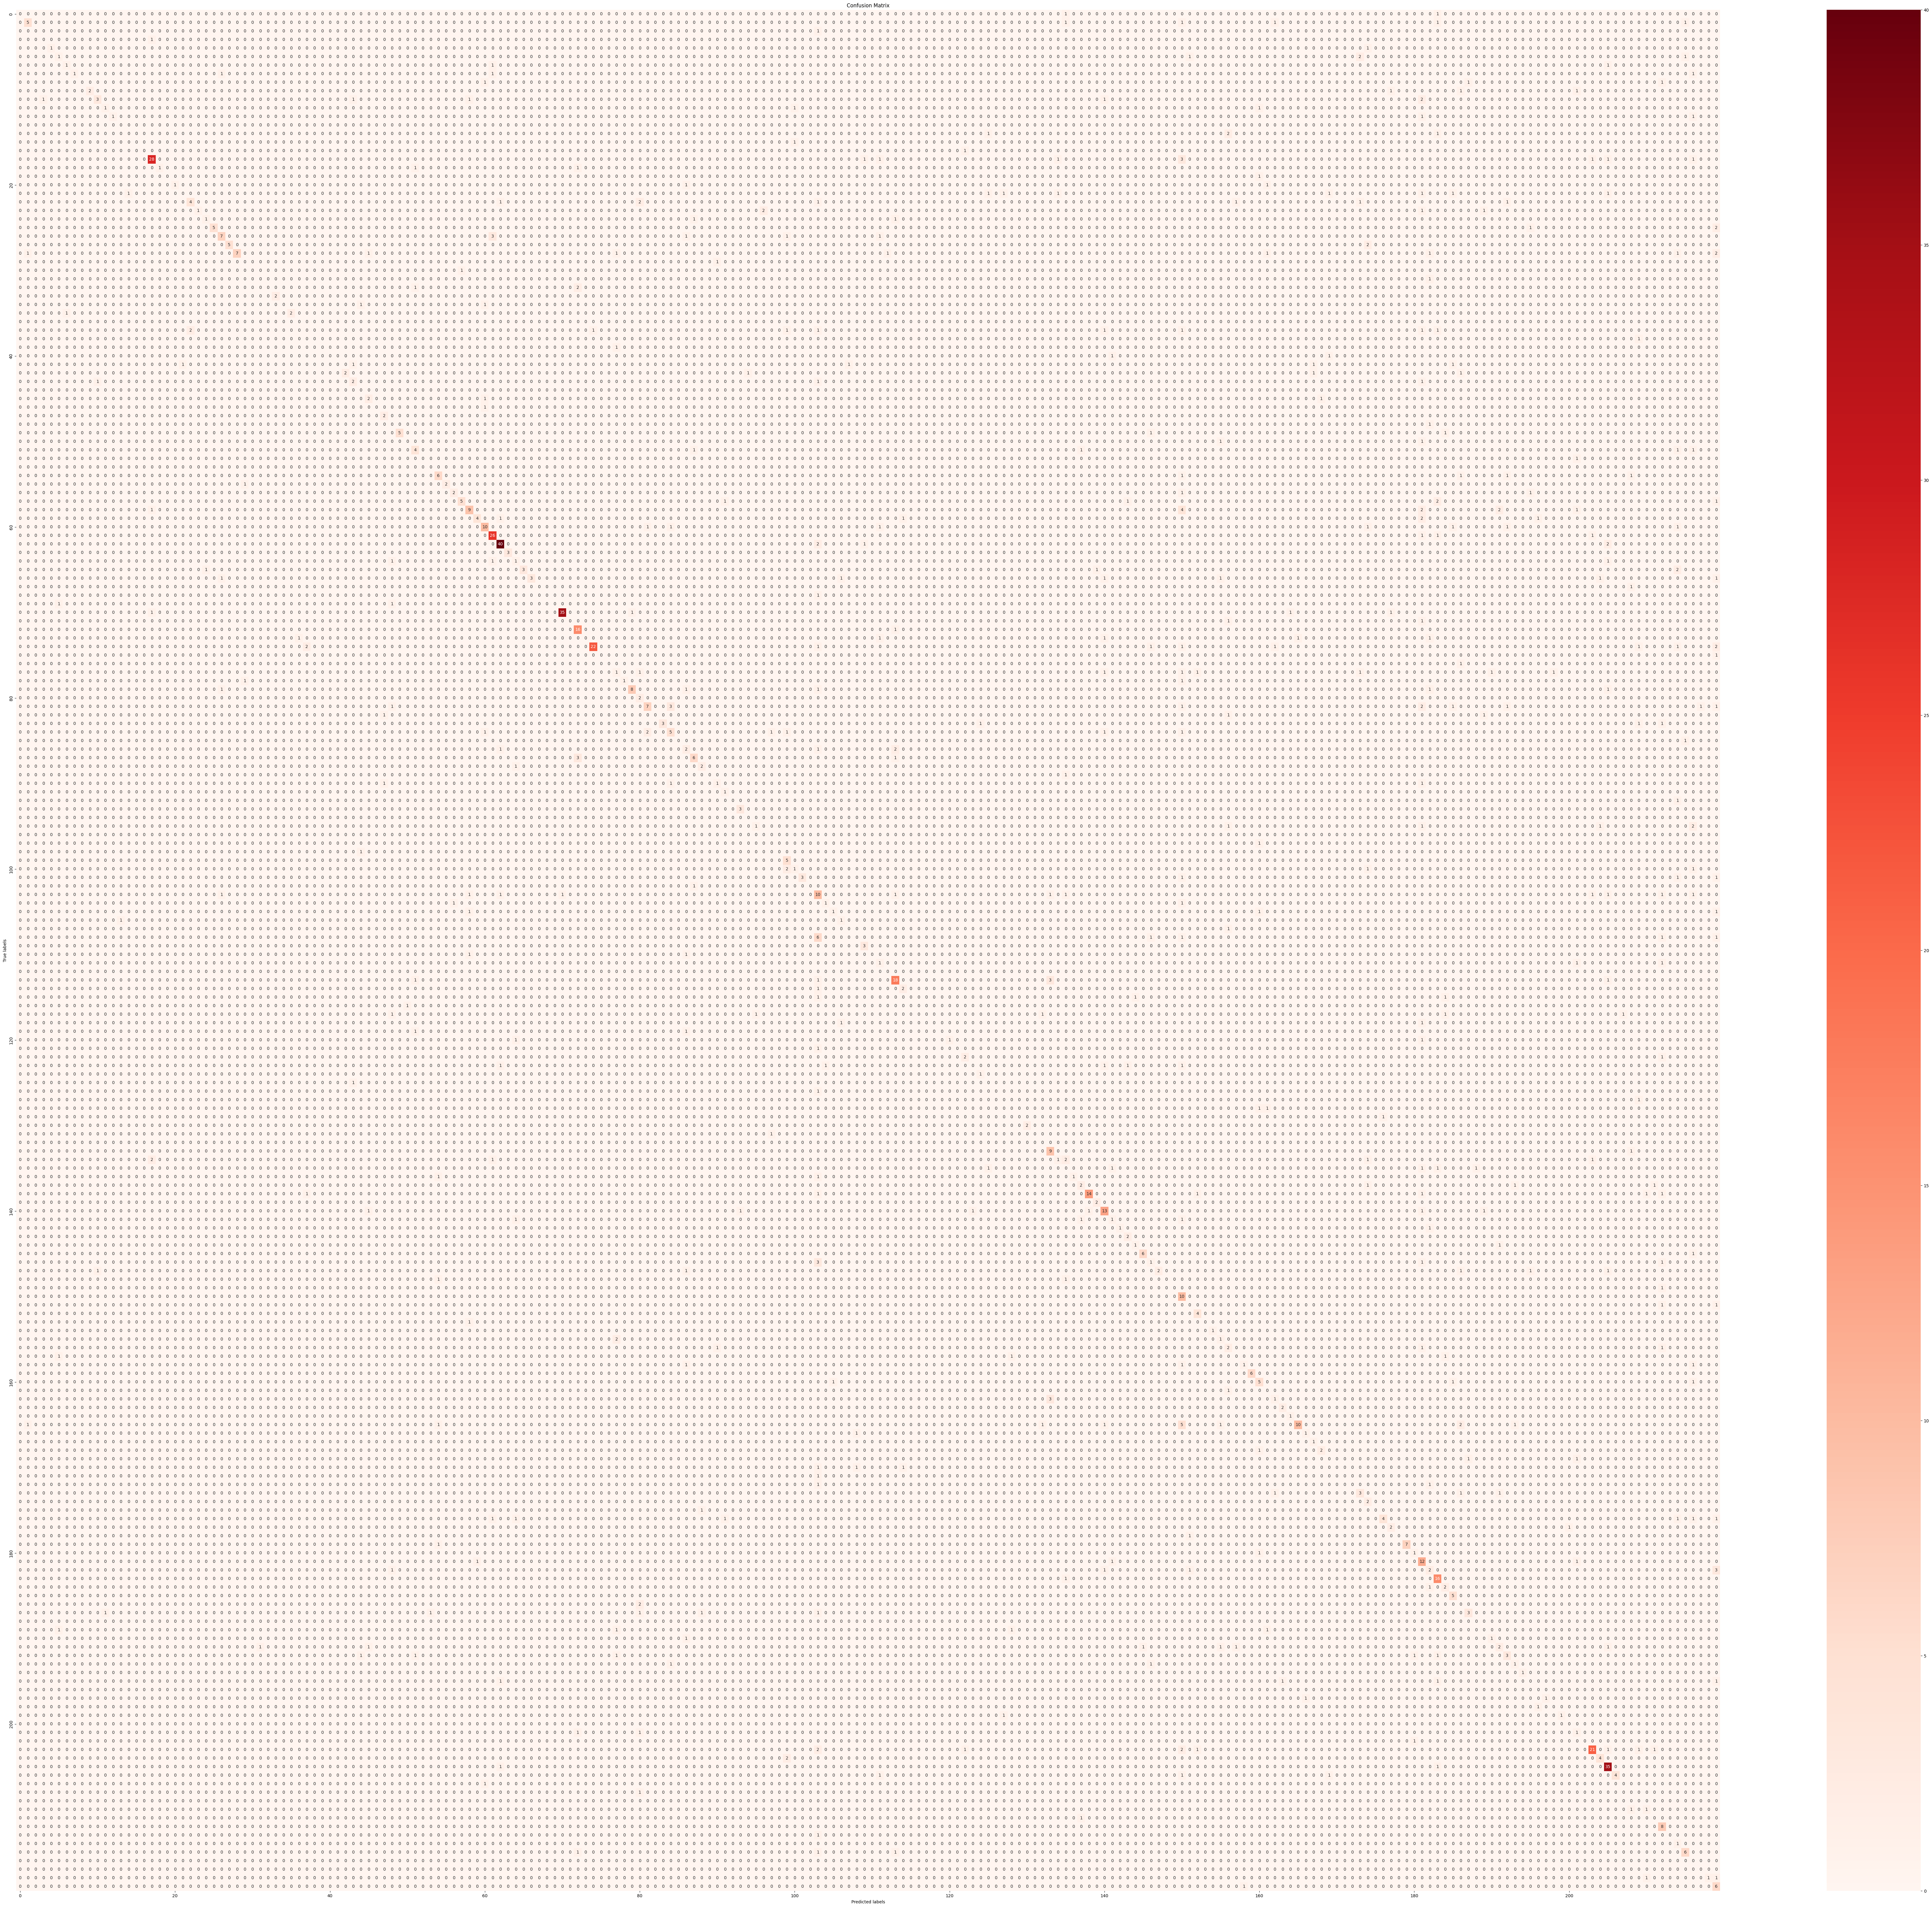

In [26]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(90, 80))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=20, yticklabels=20)
plt.savefig(f'conf_matrix_{model_name}.png')
plt.show()